In [107]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import xgboost as xgb

In [95]:
data=pd.read_csv("data_preped.csv")

In [96]:
data["date"]=pd.to_datetime(data["date"])

### Calendar trygo

In [97]:
data["month"]=data.date.dt.month
data["dayofyear"]=data.date.dt.dayofyear
data["dayofweek"]=data.date.dt.weekday
data["dayofmonth"]=data.date.dt.day

In [98]:
data["month_sin"] = np.sin(2 * np.pi * data["month"] / 12)
data["month_cos"] = np.cos(2 * np.pi * data["month"] / 12)

data["dayofweek_sin"] = np.sin(2 * np.pi * data["dayofweek"] / 7)
data["dayofweek_cos"] = np.cos(2 * np.pi * data["dayofweek"] / 7)

data["dayofmonth_sin"] = np.sin(2 * np.pi * data["dayofmonth"] / 31)
data["dayofmonth_cos"] = np.cos(2 * np.pi * data["dayofmonth"] / 31)

data["dayofyear_sin"] = np.sin(2 * np.pi * data["dayofyear"] / 365)
data["dayofyear_cos"] = np.cos(2 * np.pi * data["dayofyear"] / 365)

data.drop(["month", "dayofweek", "dayofmonth", "dayofyear"], axis=1, inplace=True)

### Lags, rolling feats

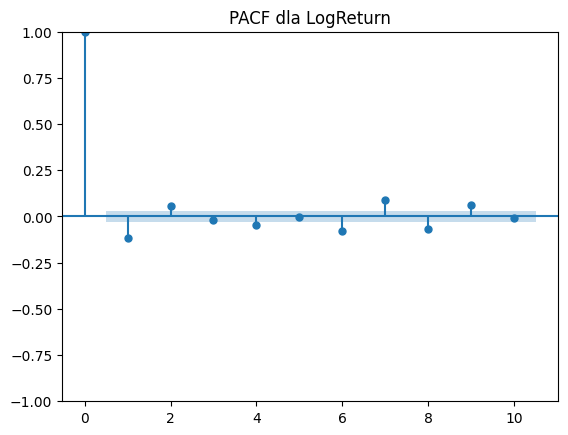

In [99]:
log_returns = data["LogReturn"].dropna()
plot_pacf(log_returns, lags=10)  # np. 30 lagów do sprawdzenia
plt.title("PACF dla LogReturn")
plt.show()

In [100]:
for i in range(1,11):
    data[f"LogReturn_lag{i}"] = data["LogReturn"].shift(i)

In [101]:
data.dropna(inplace=True)

In [102]:
data

,LogReturn,date,gdp,interest_rate,unemployment,cpi,pce,nonfarm_payrolls,corporate_profits,money_supply,...,LogReturn_lag1,LogReturn_lag2,LogReturn_lag3,LogReturn_lag4,LogReturn_lag5,LogReturn_lag6,LogReturn_lag7,LogReturn_lag8,LogReturn_lag9,LogReturn_lag10
61,0.007386,2010-04-01,16690.0,0.16,9.9,217.353,90.261,129865.0,1564.0,8523.7,...,-0.003278,0.000043,0.005667,0.000737,-0.001706,-0.005508,0.007145,0.005082,-0.005099,-0.000326
62,0.007897,2010-04-05,16690.0,0.16,9.9,217.353,90.261,129865.0,1564.0,8523.7,...,0.007386,-0.003278,0.000043,0.005667,0.000737,-0.001706,-0.005508,0.007145,0.005082,-0.005099
63,0.001683,2010-04-06,16690.0,0.16,9.9,217.353,90.261,129865.0,1564.0,8523.7,...,0.007897,0.007386,-0.003278,0.000043,0.005667,0.000737,-0.001706,-0.005508,0.007145,0.005082
64,-0.005894,2010-04-07,16690.0,0.16,9.9,217.353,90.261,129865.0,1564.0,8523.7,...,0.001683,0.007897,0.007386,-0.003278,0.000043,0.005667,0.000737,-0.001706,-0.005508,0.007145
65,0.003369,2010-04-08,16690.0,0.16,9.9,217.353,90.261,129865.0,1564.0,8523.7,...,-0.005894,0.001683,0.007897,0.007386,-0.003278,0.000043,0.005667,0.000737,-0.001706,-0.005508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3769,0.010982,2024-12-24,23542.0,4.64,4.2,316.449,124.399,158619.0,3631.0,21454.5,...,0.007261,0.010810,-0.000865,-0.029937,-0.003871,0.003792,-0.000026,-0.005429,0.008133,-0.002968
3770,-0.000406,2024-12-26,23542.0,4.64,4.2,316.449,124.399,158619.0,3631.0,21454.5,...,0.010982,0.007261,0.010810,-0.000865,-0.029937,-0.003871,0.003792,-0.000026,-0.005429,0.008133
3771,-0.011117,2024-12-27,23542.0,4.64,4.2,316.449,124.399,158619.0,3631.0,21454.5,...,-0.000406,0.010982,0.007261,0.010810,-0.000865,-0.029937,-0.003871,0.003792,-0.000026,-0.005429
3772,-0.010760,2024-12-30,23542.0,4.64,4.2,316.449,124.399,158619.0,3631.0,21454.5,...,-0.011117,-0.000406,0.010982,0.007261,0.010810,-0.000865,-0.029937,-0.003871,0.003792,-0.000026


### Normalization

In [103]:
data.columns

Index(['LogReturn', 'date', 'gdp', 'interest_rate', 'unemployment', 'cpi',
       'pce', 'nonfarm_payrolls', 'corporate_profits', 'money_supply',
       'consumer_confidence', 'housing_starts', 'permits',
       'interest_rate_lag1', 'unemployment_lag1', 'cpi_lag1', 'pce_lag1',
       'interest_rate_roll3_mean', 'interest_rate_roll3_std', 'cpi_roll3_mean',
       'cpi_roll3_std', 'interest_x_cpi', 'unemp_x_gdp', 'month_sin',
       'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofmonth_sin',
       'dayofmonth_cos', 'dayofyear_sin', 'dayofyear_cos', 'LogReturn_lag1',
       'LogReturn_lag2', 'LogReturn_lag3', 'LogReturn_lag4', 'LogReturn_lag5',
       'LogReturn_lag6', 'LogReturn_lag7', 'LogReturn_lag8', 'LogReturn_lag9',
       'LogReturn_lag10'],
      dtype='object')

In [104]:
columns_to_normalize = ['LogReturn','gdp', 'interest_rate', 'unemployment', 'cpi', 'pce', 'nonfarm_payrolls', 'corporate_profits', 
                        'money_supply', 'consumer_confidence', 'housing_starts', 'permits', 
                        'interest_rate_lag1', 'unemployment_lag1', 'cpi_lag1', 'pce_lag1', 
                        'LogReturn', 'LogReturn_lag1', 'LogReturn_lag2', 'LogReturn_lag3', 
                        'LogReturn_lag4', 'LogReturn_lag5', 'LogReturn_lag6', 'LogReturn_lag7', 
                        'LogReturn_lag8', 'LogReturn_lag9', 'LogReturn_lag10']


scaler = StandardScaler()

data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

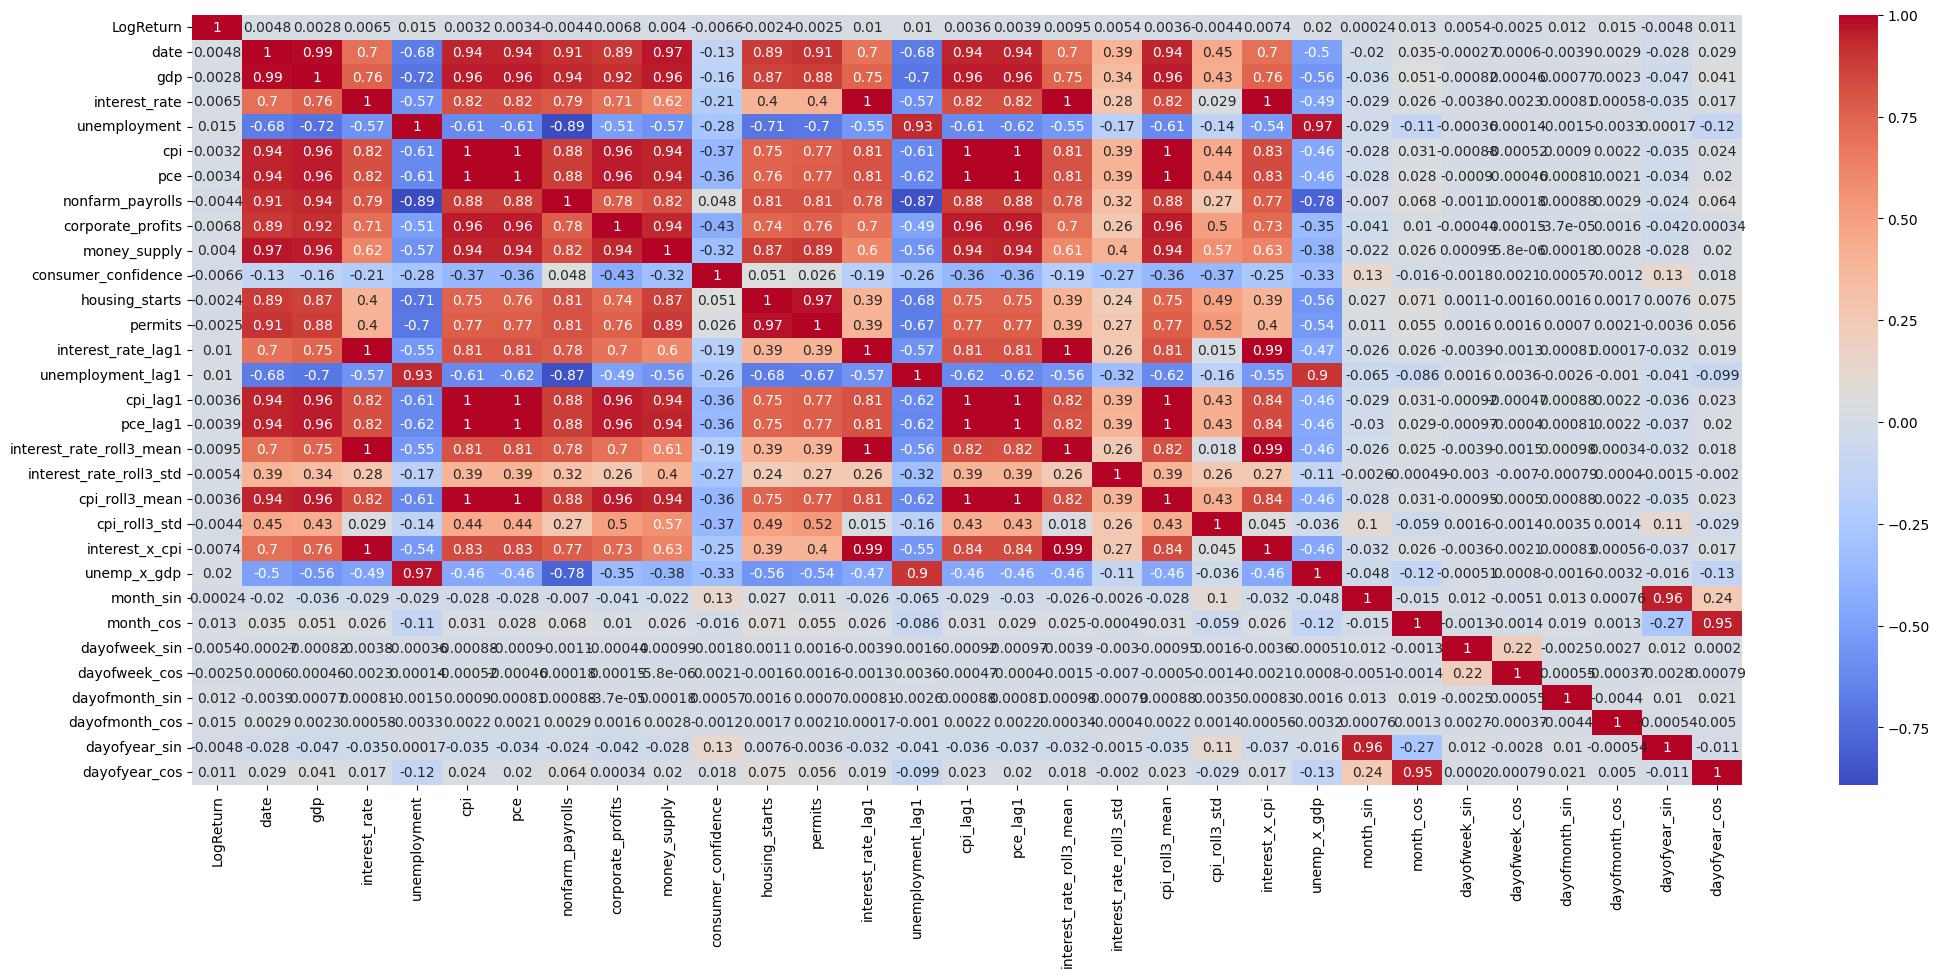

In [106]:
cor_data = data[['LogReturn', 'date', 'gdp', 'interest_rate', 'unemployment', 'cpi',
       'pce', 'nonfarm_payrolls', 'corporate_profits', 'money_supply',
       'consumer_confidence', 'housing_starts', 'permits',
       'interest_rate_lag1', 'unemployment_lag1', 'cpi_lag1', 'pce_lag1',
       'interest_rate_roll3_mean', 'interest_rate_roll3_std', 'cpi_roll3_mean',
       'cpi_roll3_std', 'interest_x_cpi', 'unemp_x_gdp', 'month_sin',
       'month_cos', 'dayofweek_sin', 'dayofweek_cos', 'dayofmonth_sin',
       'dayofmonth_cos', 'dayofyear_sin', 'dayofyear_cos']]
correlation = cor_data.corr()
plt.figure(figsize=(25,10))
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.show()

In [125]:
data.to_csv("transformed_data.csv",index=False)